In [1]:
import numpy as np
import pandas as pd
import bokeh.plotting as bp
from bokeh.layouts import gridplot
#bp.output_notebook()
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Se lee la señal pre-procesada\n",
data_set = pd.read_csv("./data/TrueFX/EUR-USD/datos_procesados_EURUSD-2017-09.csv")

In [3]:
data_set.head()

,date,bid,ask
0,2017-09-01 02:59:30,1.19097,1.19101
1,2017-09-01 02:59:40,1.19099,1.19104
2,2017-09-01 02:59:50,1.19099,1.19104
3,2017-09-01 03:00:00,1.19102,1.19105
4,2017-09-01 03:00:10,1.19101,1.19104


In [4]:
data_set = data_set.set_index(pd.to_datetime(data_set.iloc[:,0])) #se indexan los datos por su fecha y hora
data_set = data_set.drop(['date'],axis=1) #se elimina la columna date

In [5]:
data_set = data_set.drop(data_set['2017-09-17'].index) #elimina un solo registro que quedó volando

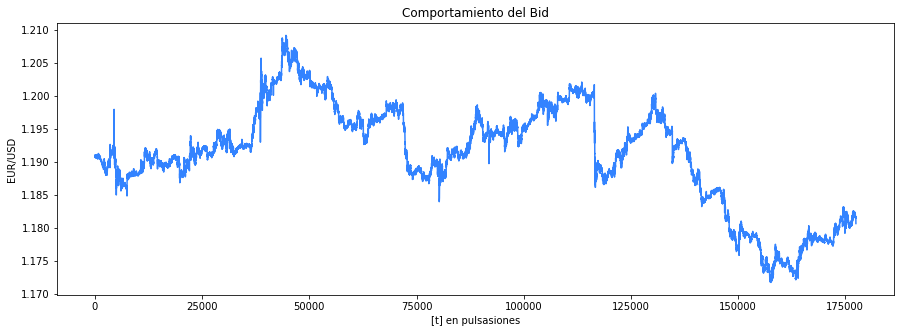

In [6]:
plt.figure(figsize=(15,5))
plt.title('Comportamiento del Bid')
plt.xlabel('[t] en pulsasiones')
plt.ylabel('EUR/USD')
plt.plot(np.arange(data_set.shape[0]), data_set.iloc[:,0], alpha=1, color='#3383FF')

In [7]:
print('                   Bussines day - year, month, day')
print()
print(pd.unique(data_set.index.date))

                   Bussines day - year, month, day

[datetime.date(2017, 9, 1) datetime.date(2017, 9, 4)
 datetime.date(2017, 9, 5) datetime.date(2017, 9, 6)
 datetime.date(2017, 9, 7) datetime.date(2017, 9, 8)
 datetime.date(2017, 9, 11) datetime.date(2017, 9, 12)
 datetime.date(2017, 9, 13) datetime.date(2017, 9, 14)
 datetime.date(2017, 9, 15) datetime.date(2017, 9, 18)
 datetime.date(2017, 9, 19) datetime.date(2017, 9, 20)
 datetime.date(2017, 9, 21) datetime.date(2017, 9, 22)
 datetime.date(2017, 9, 25) datetime.date(2017, 9, 26)
 datetime.date(2017, 9, 27) datetime.date(2017, 9, 28)
 datetime.date(2017, 9, 29)]


#### Se crea un validation split
el "v_split" se crea para entrenar y validar el rendimiento del estimador, esa función retorna un generador con los indices de los dias que se tomarán para entrenar y los dias a validar. Los parametros que ella recibe son los siguientes:

   - X, que tiene que ser un dataframe indexado por fechas.
   - n_bdtrain, un entero el cual representa los días que se utilizarán para entrenar.
   - n_bdtest, un entero el cual representa los días que se utilizarán para validar.
   - mday, entero que representa los días que se va corriendo  el estimador para validar.

In [8]:
# Se crea un generador "v_split" para utilizar como método de validación cruzada
def v_split(X, n_bdtrain, n_bdtest, mday):

    """"
    Hace un particionado del dataset, para tomar n_bdtrain días para entrenar
    y n_bdtest para probar, además, mday representa el paso de día a correr.
    X, dataframe, se necesita el indice de este para separar por días.
    n_bdtrain, número de bussines day utilizados para train.
    n_bdtest, número de bussines day utilizados para test.
    mday, días a correr para cada validación.
    
    """
    from datetime import date
    start_day = 0
    
    #Divide el data set según días de train, test y cuanto se va moviendo
    bussines_day = []
    dates = pd.unique(X.index.date) #saco las fechas para luego tomar solo año-mes-día

    for i in dates: bussines_day.append(date.__format__(i,'%Y-%m-%d')) #lista de los bussines day
    
    intervals = []
    count = 0
    for i in bussines_day:
        f = len(X[i])-1 +count
        intervals.append([count,f])
        count = f+1
    
    for i in range(len(intervals)-n_bdtrain):
        yield(np.arange(intervals[start_day:start_day+n_bdtrain][0][0],
                        intervals[start_day:start_day+n_bdtrain][n_bdtrain-1][1]+1),
              np.arange(intervals[n_bdtrain+start_day:n_bdtrain+start_day+n_bdtest][0][0],
                        intervals[n_bdtrain+start_day:n_bdtrain+start_day+n_bdtest][n_bdtest-1][1]+1))
    
        start_day += mday
        if start_day+n_bdtest > len(intervals)-n_bdtrain:
            break

In [9]:
print("train data & test data")
print("----------------------")
for i in v_split(data_set,4,1,1):
    print (i)

train data & test data
----------------------
(array([    0,     1,     2, ..., 33080, 33081, 33082]), array([33083, 33084, 33085, ..., 41610, 41611, 41612]))
(array([ 7471,  7472,  7473, ..., 41610, 41611, 41612]), array([41613, 41614, 41615, ..., 50176, 50177, 50178]))
(array([16019, 16020, 16021, ..., 50176, 50177, 50178]), array([50179, 50180, 50181, ..., 58669, 58670, 58671]))
(array([24526, 24527, 24528, ..., 58669, 58670, 58671]), array([58672, 58673, 58674, ..., 66239, 66240, 66241]))
(array([33083, 33084, 33085, ..., 66239, 66240, 66241]), array([66242, 66243, 66244, ..., 74783, 74784, 74785]))
(array([41613, 41614, 41615, ..., 74783, 74784, 74785]), array([74786, 74787, 74788, ..., 83326, 83327, 83328]))
(array([50179, 50180, 50181, ..., 83326, 83327, 83328]), array([83329, 83330, 83331, ..., 91891, 91892, 91893]))
(array([58672, 58673, 58674, ..., 91891, 91892, 91893]), array([ 91894,  91895,  91896, ..., 100434, 100435, 100436]))
(array([ 66242,  66243,  66244, ..., 100434,

#### Se crea una función para construir el dataset ####
Con "build_dataset" lo que se quiere es que mediante la señal, un tamaño de ventana y otros parámetros que explicaré a continuación se genere el dataset como un dataframe indexado por sus fechas. Los parámetros de esta función son:

   - signal, señal a procesar, tiene que ser un dataframe indexado por las fechas.
   - window, tamaño de ventana a coger, este define las columnas del dataset.
   - binary_target, por defecto es False, determina si se quiere el target binario de los datos, esto me permite trabajar con clasificación.
   - delete_constant_values, por defecto es True, dado a que son datos que fluctuan poco, al momento de crear el dataset puede que para el target este se mantenga igual, que el precio no suba ni baje, por ende estos datos los elimino.
   - PNL, por defecto es False, este agrega una columna al dataframe, la cual consiste en anotar la ganancia o perdida según si sube o baja el precio del mercado.

In [10]:
def build_dataset(signal, window, binary_target=False, delete_constant_values=True, PNL=False):
    """
    función para construir un data set
    window: tamaño de la ventana a utilizar para construir el dataset
    signal: dataframe
    binary_target: si desea clasificar, este arroja 2 si el valor se mantiene,
    1 si el valor sube y 0 si este baja.
    delete_constant_values: default: True, elimina los valores que se mantienen
    
    retorna:
    X: dataset, con columna de PNL si así se especifica(default: False)
    y: target
    bt: binary target, default: False
    """
    result = []
    binary = [] #para la columna objetivo binaria
    pnl_col = [] #almacenar el PNL
    indx = signal.index[window+1:] #se toman los indicen que quedarán al final
    for i in range(len(signal) - window-1):
        
        if delete_constant_values == True:
            if signal[i+window] != signal[i+window-1]:

                result.append(signal[i: i + window+1])
                if PNL == True: pnl_col.append(signal[i+window]-signal[i+window-1])
                
                if binary_target == True:
                    if signal[i+window] < signal[i+window-1]: binary.append(0) # 0 si baja
                    if signal[i+window] > signal[i+window-1]: binary.append(1) # 1 si sube
                        
            else: indx = indx.delete(len(result))
        else:

            result.append(signal[i: i + window+1])
            if PNL == True: pnl_col.append(signal[i+window]-signal[i+window-1])
            
        if binary_target == True and delete_constant_values == False:
            if signal[i+window] == signal[i+window-1]: binary.append(2) # 2 si se mantiene
            if signal[i+window] < signal[i+window-1]: binary.append(0) # 1 si baja
            if signal[i+window] > signal[i+window-1]: binary.append(1) # 0 si sube
    
    data = pd.DataFrame(np.array(result), index=indx)
    y = np.array(data.iloc[:,window])
    data = data.drop(window,axis=1)
    if PNL == True: data['PNL'] = pnl_col
    if binary_target == True: return data, y, np.array(binary)
    else: return data, y

In [11]:
data_set.head()

,bid,ask
date,,
2017-09-01 02:59:30,1.19097,1.19101
2017-09-01 02:59:40,1.19099,1.19104
2017-09-01 02:59:50,1.19099,1.19104
2017-09-01 03:00:00,1.19102,1.19105
2017-09-01 03:00:10,1.19101,1.19104


#### Construyendo el dataset
se prueba construyendo el dataset con una ventana de tamaño 3 ya que con esta es que se obtuvo mejores resultados.

In [12]:
window = 3
X, y_reg, bt = build_dataset(data_set.iloc[:,0], window, binary_target=True, delete_constant_values=True, PNL=True)

KeyboardInterrupt: 

In [ ]:
X.shape, bt.shape, y_reg.shape

In [ ]:
X.head()

In [ ]:
print(y_reg[:5])
print(bt[:5])

Se utiliza cross_val_score pasandole el parámetro cv para la partición del dataset a la hora de entrenar y probrar, se utiliza la función score que este trae por defecto

In [ ]:
from sklearn.model_selection import cross_val_score

y = bt

from sklearn.neighbors import KNeighborsClassifier

n_bdtrain = 4 #número de dias con los que se entrena
n_bdtest = 1  #número de días con los que se hace el test
move_day = 1  #número de días que se van corriendo

vs = v_split(X,n_bdtrain,n_bdtest,move_day)
k = KNeighborsClassifier()

for train_index, test_index in vs:
    print ('train = ',train_index, 'test = ',test_index)
print()
result = cross_val_score(k, X, y, cv=v_split(X, n_bdtrain, n_bdtest, move_day))

print(result)
print()
print('score avg = ', np.mean(result))
print('score std = ', np.std(result))

se crea la clase PNLEstimatorWrapper para crear nuestra propia función score y así retornar nuestros diferentes tipos de score

In [ ]:
class PNLEstimatorWrapper:
    
    def __init__(self, estimator, PNL_column, exclude_PNL_column_from_training=True):
        self.estimator = estimator
        self.PNL_column = PNL_column
        self.exclude_PNL_column_from_training = exclude_PNL_column_from_training
        
    def fit(self, X, y):
        assert self.PNL_column in X.columns, "column "+self.PNL_column+" not in X dataframe"
        if self.exclude_PNL_column_from_training:
            X = X[[col for col in X.columns if col!=self.PNL_column]]
        self.estimator.fit(X,y)
        
    def predict(self, X):
        assert self.PNL_column in X.columns, "column "+self.PNL_column+" not in X dataframe"
        if self.exclude_PNL_column_from_training:
            X = X[[col for col in X.columns if col!=self.PNL_column]]
        return self.estimator.predict(X)
    
    def score(self, X, y):
        PNL = X[self.PNL_column]
        pre = self.predict(X)
        r = sum((y==pre)*abs(PNL) - (y!=pre)*abs(PNL))
        sell = sum((pre==0)*1)
        buy = sum((pre==1)*1)
        
        count_ones, count_zeros = 0,0
        l_one, l_zero = [],[]
        for i in pre:
            if i==1:
                l_zero.append(count_zeros)
                count_zeros = 0
                count_ones += 1
            else:
                l_one.append(count_ones)
                count_zeros += 1
                count_ones = 0
        l_zero.append(count_zeros)
        l_one.append(count_ones)
        
        #return np.array([r,buy,sell,max(l_one),max(l_zero)])
        return np.array([r,buy,sell,max(l_one),max(l_zero)]), pre
        
    def get_params(self, deep=False):
        return {"PNL_column": self.PNL_column,
                "exclude_PNL_column_from_training": self.exclude_PNL_column_from_training,
                "estimator": self.estimator}

#### creando la función step_validation
esta función me recibe el estimador en el cual va implicita la clase PNLEstimatorWrapper, lo que hace es coger el generador "v_split" para aplicarlo con el estimador y así validar los datos.


In [ ]:
def step_validation(estimator, X, y, cv):
    '''
    Recibe el estimador,X,y, y un generador cv con el cual hace la validación
    dependiendo que la configuración que este tenga
    '''
    result = []
    for index in cv:
        estimator.fit(X.iloc[index[0]], y[index[0]])
        result.append(estimator.score(X.iloc[index[1]], y[index[1]]))
    return np.array(result)

Debido a que la función score arroja un vector que en cada posición tiene un vector con datos del PNL y otro con las predicciones, se hace necesario crear una función llamada "redim" para tratar esta salida y poder separar los datos del PNL y los del predict.

In [ ]:
def redim(signal):
    '''
    recibe un array plano el cual convierte en dos salidas,
    en una de estas se encuentran los resultados pertinentes
    a medir con el PNL y en el otro las predicciones.
    '''
    result = signal[:,0][0]
    predict = np.array(signal[:,1][0],dtype=np.float16)
    for i in range(1,len(signal)):
        result = np.concatenate((result,signal[:,0][i]))
        predict = np.concatenate((predict,signal[:,1][i]))
    result = result.reshape((len(signal),signal[:,0][0].shape[0]))
    return result, predict

Se prueba con un GaussianNB para ver su rendimiento, esto teniendo cuenta que solo es con un mes de datos

In [ ]:
from sklearn.naive_bayes import GaussianNB
    
est_GNB = PNLEstimatorWrapper(GaussianNB(), PNL_column='PNL')
result_GNB = step_validation(est_GNB, X, y, v_split(X,4,1,1))
result_GNB, predict_GNB = redim(result_GNB)
print('--------- GaussianNB ----------------')
print('average PNL : ', np.mean(result_GNB[:,0]))
print('average buy: ', np.mean(result_GNB[:,1]))
print('average sell: ', np.mean(result_GNB[:,2]))
print('-------------------------------------')
print(pd.DataFrame(result_GNB, columns=list(['PNL','buys','sells','longest_buys','longest_sells'])))

### Se pintarán las ventas en color rojo y las compras en color verde!

para poder graficar la señal original con las predicciones, hay que tener en cuenta que los primeros 4 días que se eligieron anteriormente en la variable "n_bdtrain" se deben omitir.

In [ ]:
firts_4bd = 27900 #primeros 4 días

el vector de predicción tiene el mismo tamaño que el vector de target, teniendo en cuenta que este empieza después de los 4 días que tenemos para entrenar desde un principio

In [ ]:
len(predict_GNB),len(y)- firts_4bd

In [ ]:
buy_GNB = (predict_GNB==1)*y_reg[firts_4bd:] #para graficar las compras sobre la señal original
buy_GNB[buy_GNB==0] = np.nan 
print (buy_GNB.shape)

sell_GNB = (predict_GNB==0)*y_reg[firts_4bd:] #para graficar las ventas sobre la señal original
sell_GNB[sell_GNB==0] = np.nan
print (sell_GNB.shape)

In [ ]:
dates = np.unique(data_set.index.date) #para graficas el numero de ventas y comprar por dia
x_axis = X.index[firts_4bd:] #para graficar los resultados por datetime

In [ ]:
x_axis.shape, sell_GNB.shape

In [ ]:
x_axis

graficando con bokeh...

In [60]:
p1_GNB = bp.figure(width=750, height=300,title='buys and sells with a GaussianNB',x_axis_type='datetime',
               title_location = 'above')
p1_GNB.triangle(x_axis, buy_GNB, color='green', legend='buys')
p1_GNB.xaxis.axis_label = 'Datetime'
p1_GNB.yaxis.axis_label = 'EUR/USD'
p1_GNB.triangle(x_axis, sell_GNB, color='red', angle=45, legend='sells')
p1_GNB.line(x_axis, y_reg[firts_4bd:], color='blue', alpha=0.2, legend='bid')

p2_GNB = bp.figure(width=750, height=300,title='Profit and Loss with a GaussianNB',x_axis_type='datetime')
p2_GNB.line(dates[n_bdtrain:], result_GNB[:,0], color='blue', legend='PNL', alpha=0.5)
p2_GNB.circle(dates[n_bdtrain:], result_GNB[:,0], color='blue', legend='PNL', alpha=0.5)
p2_GNB.line(dates[n_bdtrain:], np.zeros(len(result_GNB)), color='red', legend='PNL = 0', line_dash='dotted')
p2_GNB.line(dates[n_bdtrain:],np.ones(len(result_GNB[:,0]))*np.mean(result_GNB[:,0]),color='green',legend='avg PNL')
p2_GNB.xaxis.axis_label = 'datetime'
p2_GNB.yaxis.axis_label = 'PNL'
p2_GNB.legend.location ='bottom_center'
p2_GNB.legend.orientation = 'horizontal'

p3_GNB = bp.figure(width=400, height=250, title='buys per day', x_axis_type='datetime')
p3_GNB.line(dates[n_bdtrain:], result_GNB[:,1], color='green')
p3_GNB.circle(dates[n_bdtrain:], result_GNB[:,1], color='green')
p3_GNB.xaxis.axis_label = 'datetime'
p3_GNB.yaxis.axis_label = 'buys per day'

p4_GNB = bp.figure(width=400, height=250, title='sells per day', x_axis_type='datetime')
p4_GNB.line(dates[n_bdtrain:], result_GNB[:,2], color='red')
p4_GNB.circle(dates[n_bdtrain:], result_GNB[:,2], color='red')
p4_GNB.xaxis.axis_label = 'datetime'
p4_GNB.yaxis.axis_label = 'sells per day'

bp.show(gridplot([[p1_GNB,p3_GNB],[p2_GNB,p4_GNB]], toolbar_location="right"))
bp.output_file(filename='grafico GaussianNB.html', title='GaussianNB')
#bp.reset_output()
#bp.save(bp.curdoc(), filename='grafico GaussianNB.html', title='GaussianNB')

se gráfica el PNL y su media para poder ver graficamente las veces que se gana o se pierde y si en general se termina ganando o perdiendo dinero

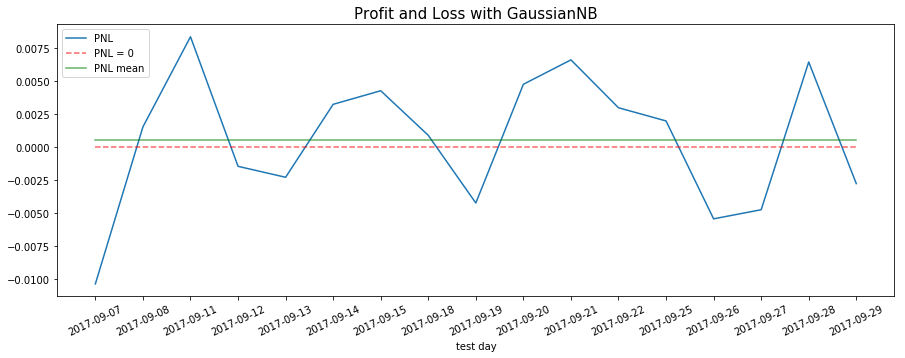

In [61]:
plt.figure(figsize=(15,5))
    
plt.title('Profit and Loss with GaussianNB', size=15)
plt.plot(range(len(result_GNB[:,0])), result_GNB[:,0], label='PNL')
plt.plot(range(len(result_GNB[:,0])), np.zeros(len(result_GNB[:,0])),color='red', alpha=0.6, label='PNL = 0', linestyle='--')
plt.plot(range(len(result_GNB[:,0])), np.ones(len(result_GNB[:,0]))*np.mean(result_GNB[:,0]),
         color='green', alpha=0.6, label='PNL mean')
plt.xlabel('test day')
plt.xticks(range(len(result_GNB)),dates[n_bdtrain:], size=10, rotation=25)
plt.legend();

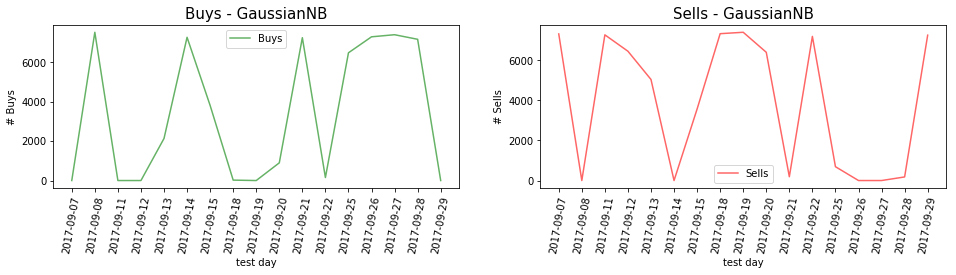

In [62]:
plt.figure(figsize=(16,3))
plt.subplot(1,2,1)
plt.title('Buys - GaussianNB', size=15)
plt.plot(range(len(result_GNB[:,1])), result_GNB[:,1],color='green', alpha=0.6, label='Buys')
plt.xlabel('test day')
plt.ylabel('# Buys')
plt.xticks(range(len(result_GNB)),dates[n_bdtrain:], size=10, rotation=80)
plt.legend();
    
plt.subplot(1,2,2)
plt.title('Sells - GaussianNB', size=15)
plt.plot(range(len(result_GNB[:,2])), result_GNB[:,2],color='red', alpha=0.6, label='Sells')
plt.xlabel('test day')
plt.ylabel('# Sells')
plt.xticks(range(len(result_GNB)),dates[n_bdtrain:], size=10, rotation=80)
plt.legend();

Se prueba con un KNeighborsClassifier

In [63]:
from sklearn.neighbors import KNeighborsClassifier

est_KNC = PNLEstimatorWrapper(KNeighborsClassifier(n_neighbors=7,n_jobs=2,leaf_size=30
                                                   ,algorithm='kd_tree'), PNL_column='PNL')
result_KNC = step_validation(est_KNC, X, y, v_split(X,4,1,1))
result_KNC, predict_KNC = redim(result_KNC)
print('-------- KNeighborsClassifier -------')
print('average PNL: ', np.mean(result_KNC[:,0]))
print('average buy: ', np.mean(result_KNC[:,1]))
print('average sell: ', np.mean(result_KNC[:,2]))
print('-------------------------------------')
print(pd.DataFrame(result_KNC, columns=list(['PNL','buys','sells','longest_buys','longest_sells'])))

-------- KNeighborsClassifier -------
average PNL:  0.000774117647058
average buy:  3653.58823529
average sell:  3618.41176471
-------------------------------------
        PNL    buys   sells  longest_buys  longest_sells
0   0.00180  1463.0  5847.0          10.0         2742.0
1  -0.01208  4478.0  3045.0         319.0           76.0
2  -0.00349  3338.0  3926.0          61.0           60.0
3   0.00069  3081.0  3366.0          14.0           19.0
4  -0.00092  4387.0  2785.0        1783.0           17.0
5   0.01233  3856.0  3412.0          96.0           33.0
6  -0.01360  3688.0  3689.0          32.0           53.0
7   0.00354  3497.0  3846.0          20.0           24.0
8  -0.00211  2687.0  4705.0          15.0          747.0
9   0.00541  2006.0  5286.0          14.0         1330.0
10  0.00572  4600.0  2838.0         313.0           15.0
11  0.00055  3625.0  3715.0          14.0           14.0
12  0.00273  2881.0  4291.0          51.0          994.0
13 -0.00079  5612.0  1681.0        42

#### Pintando con bokeh, se guarda la imagen debido a que consume una cantidad de memoria RAM considerable

In [64]:
#si las predicciones son iguales a uno, esto quiere decir que subirá el precio en el mercado,
#por ende tengo que comprar
buy_KNC = (predict_KNC==1)*y_reg[firts_4bd:]
buy_KNC[buy_KNC==0] = np.nan
print (buy_KNC.shape)

sell_KNC = (predict_KNC==0)*y_reg[firts_4bd:]
sell_KNC[sell_KNC==0] = np.nan
print (sell_KNC.shape)

(123624,)
(123624,)


al parecer si uso bp.reset_output y luego ejecuto dos veces la celda de graficar, esto no me genera conflicto

In [ ]:
bp.reset_output()

In [68]:
p1_KNC = bp.figure(width=750, height=300,title='buys and sells with a KNeighborsClassifier',x_axis_type='datetime',
               title_location = 'above')
p1_KNC.triangle(x_axis, buy_KNC, color='green', legend='buys')
p1_KNC.xaxis.axis_label = 'Datetime'
p1_KNC.yaxis.axis_label = 'EUR/USD'
p1_KNC.triangle(x_axis, sell_KNC, color='red', angle=45, legend='sells')
p1_KNC.line(x_axis, y_reg[firts_4bd:], color='blue', alpha=0.2, legend='bid')

p2_KNC = bp.figure(width=750, height=300,title='Profit and Loss with a KNeighborsClassifier',x_axis_type='datetime')
p2_KNC.line(dates[n_bdtrain:], result_KNC[:,0], color='blue', legend='PNL', alpha=0.5)
p2_KNC.circle(dates[n_bdtrain:], result_KNC[:,0], color='blue', legend='PNL', alpha=0.5)
p2_KNC.line(dates[n_bdtrain:], np.zeros(len(result_KNC)), color='red', legend='PNL = 0', line_dash='dotted')
p2_KNC.line(dates[n_bdtrain:],np.ones(len(result_KNC[:,0]))*np.mean(result_KNC[:,0]),color='green',legend='avg PNL')
p2_KNC.xaxis.axis_label = 'datetime'
p2_KNC.yaxis.axis_label = 'PNL'
p2_KNC.legend.location ='bottom_right'
p2_KNC.legend.orientation = 'horizontal'

p3_KNC = bp.figure(width=400, height=250, title='buys per day', x_axis_type='datetime')
p3_KNC.line(dates[n_bdtrain:], result_KNC[:,1], color='green')
p3_KNC.circle(dates[n_bdtrain:], result_KNC[:,1], color='green')
p3_KNC.xaxis.axis_label = 'datetime'
p3_KNC.yaxis.axis_label = 'buys per day'

p4_KNC = bp.figure(width=400, height=250, title='sells per day', x_axis_type='datetime')
p4_KNC.line(dates[n_bdtrain:], result_KNC[:,2], color='red')
p4_KNC.circle(dates[n_bdtrain:], result_KNC[:,2], color='red')
p4_KNC.xaxis.axis_label = 'datetime'
p4_KNC.yaxis.axis_label = 'sells per day'

bp.show(gridplot([[p1_KNC,p3_KNC],[p2_KNC,p4_KNC]], toolbar_location="right"))
bp.output_file(filename='grafico KNeihgborsClassifier.html', title='KNeihgborsClassifier')
#bp.save(bp.curdoc(), filename='grafico KNeihgborsClassifier.html', title='KNeihgborsClassifier')
#bp.reset_output()

se gráfica el PNL y su media para poder ver graficamente las veces que se gana o se pierde y si en general se termina ganando o perdiendo dinero

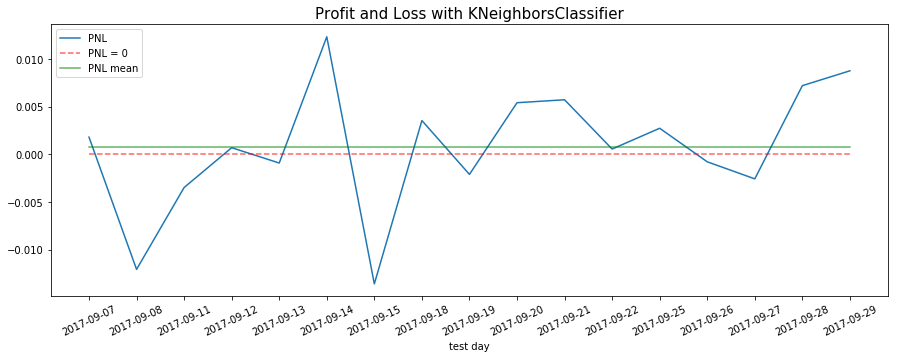

In [69]:
plt.figure(figsize=(15,5))
    
plt.title('Profit and Loss with KNeighborsClassifier', size=15)
plt.plot(range(len(result_KNC[:,0])), result_KNC[:,0], label='PNL')
plt.plot(range(len(result_KNC[:,0])), np.zeros(len(result_KNC[:,0])),color='red', alpha=0.6, label='PNL = 0', linestyle='--')
plt.plot(range(len(result_KNC[:,0])), np.ones(len(result_KNC[:,0]))*np.mean(result_KNC[:,0]),
         color='green', alpha=0.6, label='PNL mean')
plt.xlabel('test day')
plt.xticks(range(len(result_KNC)),dates[n_bdtrain:], size=10, rotation=25)
plt.legend();

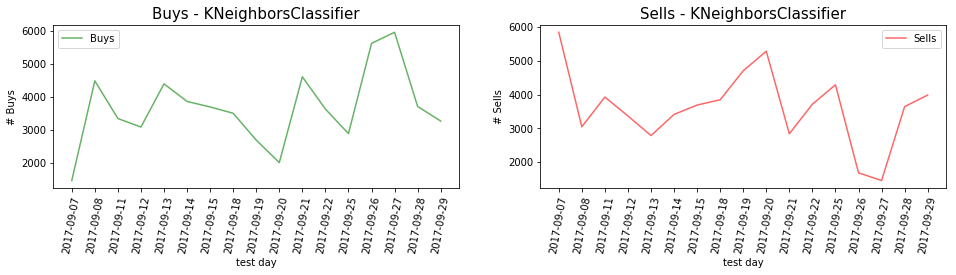

In [70]:
plt.figure(figsize=(16,3))
plt.subplot(1,2,1)
plt.title('Buys - KNeighborsClassifier', size=15)
plt.plot(range(len(result_KNC[:,1])), result_KNC[:,1],color='green', alpha=0.6, label='Buys')
plt.xlabel('test day')
plt.ylabel('# Buys')
plt.xticks(range(len(result_KNC)),dates[n_bdtrain:], size=10, rotation=80)
plt.legend();

plt.subplot(1,2,2)
plt.title('Sells - KNeighborsClassifier', size=15)
plt.plot(range(len(result_KNC[:,2])), result_KNC[:,2],color='red', alpha=0.6, label='Sells')
plt.xlabel('test day')
plt.ylabel('# Sells')
plt.xticks(range(len(result_KNC)),dates[n_bdtrain:], size=10, rotation=80)
plt.legend();

se prueba con un DecisionTreeClassifier

In [71]:
from sklearn.tree import DecisionTreeClassifier

est_DTC = PNLEstimatorWrapper(DecisionTreeClassifier(), PNL_column='PNL')
result_DTC = step_validation(est_DTC, X, y, v_split(X,4,1,1))
result_DTC, predict_DTC = redim(result_DTC)
print('------ DecisionTreeClassifier -------')
print('average PNL: ', np.mean(result_DTC[:,0]))
print('average buy: ', np.mean(result_DTC[:,1]))
print('average sell: ', np.mean(result_DTC[:,2]))
print('-------------------------------------')
print(pd.DataFrame(result_DTC, columns=list(['PNL','buys','sells','longest_buys','longest_sells'])))

------ DecisionTreeClassifier -------
average PNL:  0.00164235294118
average buy:  3681.35294118
average sell:  3590.64705882
-------------------------------------
        PNL    buys   sells  longest_buys  longest_sells
0   0.00148  1630.0  5680.0          20.0         2738.0
1  -0.00520  5004.0  2519.0        1279.0           57.0
2  -0.00451  3527.0  3737.0          26.0           38.0
3  -0.00159  3111.0  3336.0          16.0           22.0
4  -0.00326  4465.0  2707.0        1761.0           20.0
5   0.00293  3747.0  3521.0          88.0           32.0
6   0.00152  3422.0  3955.0          18.0           35.0
7   0.00836  3560.0  3783.0          15.0           24.0
8   0.01081  2874.0  4518.0          14.0          364.0
9   0.00817  2248.0  5044.0          13.0         1329.0
10 -0.00398  3930.0  3508.0          33.0           35.0
11  0.00093  3523.0  3817.0          16.0           11.0
12  0.01425  2820.0  4352.0          49.0         1699.0
13 -0.00369  5880.0  1413.0        421

In [72]:
#si las predicciones son iguales a uno, esto quiere decir que subirá el precio en el mercado,
#por ende tengo que comprar
buy_DTC = (predict_DTC==1)*y_reg[firts_4bd:]
buy_DTC[buy_DTC==0] = np.nan
print (buy_DTC.shape)

sell_DTC = (predict_DTC==0)*y_reg[firts_4bd:]
sell_DTC[sell_DTC==0] = np.nan
print (sell_DTC.shape)

(123624,)
(123624,)


se guarda el gráfico de bokeh debido que si se pinta en el jupyter se va consumiendo mucha memoria ram

In [73]:
bp.reset_output()

In [75]:
p1_DTC = bp.figure(width=750, height=300,title='buys and sells with a DecisionTreeClassifier',x_axis_type='datetime',
               title_location = 'above')
p1_DTC.triangle(x_axis, buy_DTC, color='green', legend='buys')
p1_DTC.xaxis.axis_label = 'Datetime'
p1_DTC.yaxis.axis_label = 'EUR/USD'
p1_DTC.triangle(x_axis, sell_DTC, color='red', angle=45, legend='sells')
p1_DTC.line(x_axis, y_reg[firts_4bd:], color='blue', alpha=0.2, legend='bid')

p2_DTC = bp.figure(width=750, height=300,title='Profit and Loss with a DecisionTreeClassifier',x_axis_type='datetime')
p2_DTC.line(dates[n_bdtrain:], result_DTC[:,0], color='blue', legend='PNL', alpha=0.5)
p2_DTC.circle(dates[n_bdtrain:], result_DTC[:,0], color='blue', legend='PNL', alpha=0.5)
p2_DTC.line(dates[n_bdtrain:], np.zeros(len(result_DTC)), color='red', legend='PNL = 0', line_dash='dotted')
p2_DTC.line(dates[n_bdtrain:],np.ones(len(result_DTC[:,0]))*np.mean(result_DTC[:,0]),color='green',legend='avg PNL')
p2_DTC.xaxis.axis_label = 'datetime'
p2_DTC.yaxis.axis_label = 'PNL'
p2_DTC.legend.location ='bottom_right'
p2_DTC.legend.orientation = 'horizontal'

p3_DTC = bp.figure(width=400, height=250, title='buys per day', x_axis_type='datetime')
p3_DTC.line(dates[n_bdtrain:], result_DTC[:,1], color='green')
p3_DTC.circle(dates[n_bdtrain:], result_DTC[:,1], color='green')
p3_DTC.xaxis.axis_label = 'datetime'
p3_DTC.yaxis.axis_label = 'buys per day'

p4_DTC = bp.figure(width=400, height=250, title='sells per day', x_axis_type='datetime')
p4_DTC.line(dates[n_bdtrain:], result_DTC[:,2], color='red')
p4_DTC.circle(dates[n_bdtrain:], result_DTC[:,2], color='red')
p4_DTC.xaxis.axis_label = 'datetime'
p4_DTC.yaxis.axis_label = 'sells per day'

bp.show(gridplot([[p1_DTC,p3_DTC],[p2_DTC,p4_DTC]], toolbar_location="right"))
bp.output_file(filename='grafico DecisionTreeClassifier.html')
#bp.reset_output()

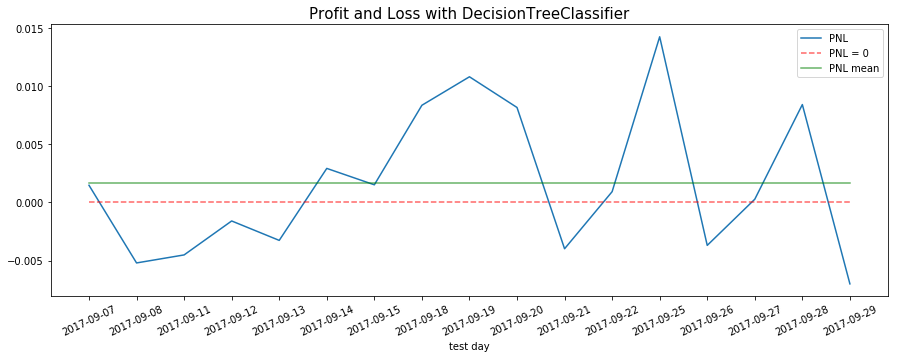

In [76]:
plt.figure(figsize=(15,5))

plt.title('Profit and Loss with DecisionTreeClassifier', size=15)
plt.plot(range(len(result_DTC[:,0])), result_DTC[:,0], label='PNL')
plt.plot(range(len(result_DTC[:,0])), np.zeros(len(result_DTC[:,0])),color='red', alpha=0.6, label='PNL = 0', linestyle='--')
plt.plot(range(len(result_DTC[:,0])), np.ones(len(result_DTC[:,0]))*np.mean(result_DTC[:,0]),
         color='green', alpha=0.6, label='PNL mean')
plt.xlabel('test day')
plt.xticks(range(len(result_DTC)),dates[n_bdtrain:], size=10, rotation=25)
plt.legend();

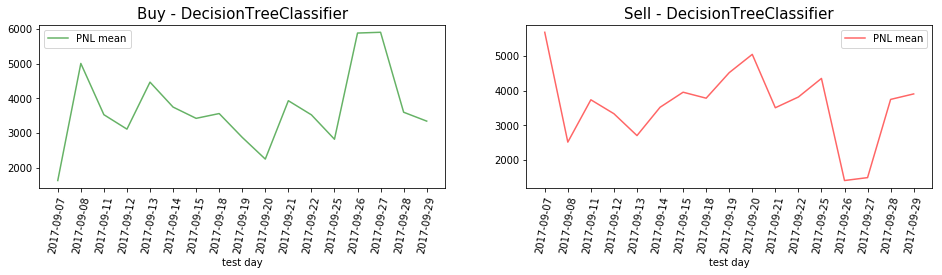

In [77]:
plt.figure(figsize=(16,3))
plt.subplot(1,2,1)
plt.title('Buy - DecisionTreeClassifier', size=15),
plt.plot(range(len(result_DTC[:,1])), result_DTC[:,1],color='green', alpha=0.6, label='PNL mean')
plt.xlabel('test day')
plt.xticks(range(len(result_DTC)),dates[n_bdtrain:], size=10, rotation=80)
plt.legend();

plt.subplot(1,2,2)
plt.title('Sell - DecisionTreeClassifier', size=15)
plt.plot(range(len(result_DTC[:,2])), result_DTC[:,2],color='red', alpha=0.6, label='PNL mean')
plt.xlabel('test day')
plt.xticks(range(len(result_DTC)),dates[n_bdtrain:], size=10, rotation=80)
plt.legend();

probando con un RandomForestClassifier, con ciertos parametros establecidos los cuales me han arrojado mejores resultados

In [78]:
from sklearn.ensemble import RandomForestClassifier

est_RFC = PNLEstimatorWrapper(RandomForestClassifier(n_estimators=15, n_jobs=3), PNL_column='PNL')
result_RFC = step_validation(est_RFC, X, y, v_split(X,4,1,1))
result_RFC, predict_RFC = redim(result_RFC)
print('RandomForestClassifier')
print('PNL promedio: ', np.mean(result_RFC[:,0]))
print('buy promedio: ', np.mean(result_RFC[:,1]))
print('sell promedio: ', np.mean(result_RFC[:,2]))
print('-------------------------------------')
print(pd.DataFrame(result_RFC, columns=list(['PNL','buys','sells','longest_buys','longest_sells'])))

RandomForestClassifier
PNL promedio:  0.000330588235295
buy promedio:  3770.05882353
sell promedio:  3501.94117647
-------------------------------------
        PNL    buys   sells  longest_buys  longest_sells
0  -0.00132  1625.0  5685.0          18.0         2740.0
1   0.00050  4467.0  3056.0        1278.0          121.0
2  -0.00713  3282.0  3982.0          38.0           59.0
3   0.00055  3059.0  3388.0          13.0           21.0
4   0.00066  4482.0  2690.0        1747.0           14.0
5   0.00495  4002.0  3266.0          98.0           20.0
6  -0.01330  3715.0  3662.0          32.0           58.0
7   0.00432  3473.0  3870.0          13.0           21.0
8  -0.00283  2862.0  4530.0          13.0          365.0
9   0.00015  2115.0  5177.0          11.0         1330.0
10  0.00032  4345.0  3093.0          57.0           20.0
11  0.00665  3601.0  3739.0          14.0           15.0
12  0.00143  4541.0  2631.0        1698.0           28.0
13 -0.00415  5673.0  1620.0        4206.0        

In [79]:
#si las predicciones son iguales a uno, esto quiere decir que subirá el precio en el mercado,
#por ende tengo que comprar
buy_RFC = (predict_RFC==1)*y_reg[firts_4bd:]
buy_RFC[buy_RFC==0] = np.nan
print (buy_RFC.shape)

#si las predicciones son iguales a cero, esto quiere decir que bajará el precio en el mercado,
#por ende tengo que vender
sell_RFC = (predict_RFC==0)*y_reg[firts_4bd:]
sell_RFC[sell_RFC==0] = np.nan
print (sell_RFC.shape)

(123624,)
(123624,)


In [80]:
bp.reset_output()

In [82]:
p1_RFC = bp.figure(width=750, height=300,title='buys and sells with a RandomForestClassifier',x_axis_type='datetime',
               title_location = 'above')
p1_RFC.triangle(x_axis, buy_RFC, color='green', legend='buys')
p1_RFC.xaxis.axis_label = 'Datetime'
p1_RFC.yaxis.axis_label = 'EUR/USD'
p1_RFC.triangle(x_axis, sell_RFC, color='red', angle=45, legend='sells')
p1_RFC.line(x_axis, y_reg[firts_4bd:], color='blue', alpha=0.2, legend='bid')

p2_RFC = bp.figure(width=750, height=300,title='Profit and Loss with a RandomForestClassifier',x_axis_type='datetime')
p2_RFC.line(dates[n_bdtrain:], result_RFC[:,0], color='blue', legend='PNL', alpha=0.5)
p2_RFC.circle(dates[n_bdtrain:], result_RFC[:,0], color='blue', legend='PNL', alpha=0.5)
p2_RFC.line(dates[n_bdtrain:], np.zeros(len(result_RFC)), color='red', legend='PNL = 0', line_dash='dotted')
p2_RFC.line(dates[n_bdtrain:],np.ones(len(result_RFC[:,0]))*np.mean(result_RFC[:,0]),color='green',legend='avg PNL')
p2_RFC.xaxis.axis_label = 'datetime'
p2_RFC.yaxis.axis_label = 'PNL'
p2_RFC.legend.location ='bottom_right'
p2_RFC.legend.orientation = 'horizontal'

p3_RFC = bp.figure(width=400, height=250, title='buys per day', x_axis_type='datetime')
p3_RFC.line(dates[n_bdtrain:], result_RFC[:,1], color='green')
p3_RFC.circle(dates[n_bdtrain:], result_RFC[:,1], color='green')
p3_RFC.xaxis.axis_label = 'datetime'
p3_RFC.yaxis.axis_label = 'buys per day'

p4_RFC = bp.figure(width=400, height=250, title='sells per day', x_axis_type='datetime')
p4_RFC.line(dates[n_bdtrain:], result_RFC[:,2], color='red')
p4_RFC.circle(dates[n_bdtrain:], result_RFC[:,2], color='red')
p4_RFC.xaxis.axis_label = 'datetime'
p4_RFC.yaxis.axis_label = 'sells per day'

bp.show(gridplot([[p1_RFC,p3_RFC],[p2_RFC,p4_RFC]], toolbar_location="right"))
bp.output_file(filename='grafico RandomForestClassifier.html')

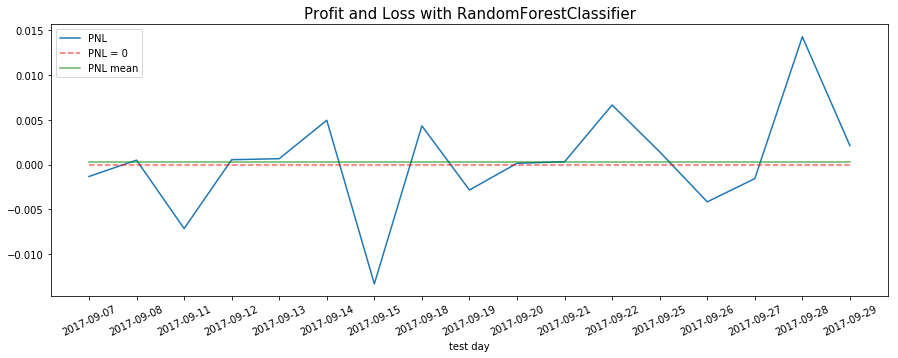

In [83]:
plt.figure(figsize=(15,5))

plt.title('Profit and Loss with RandomForestClassifier', size=15)
plt.plot(range(len(result_RFC[:,0])), result_RFC[:,0], label='PNL')
plt.plot(range(len(result_RFC[:,0])), np.zeros(len(result_RFC[:,0])),color='red', alpha=0.6, label='PNL = 0', linestyle='--')
plt.plot(range(len(result_RFC[:,0])), np.ones(len(result_RFC[:,0]))*np.mean(result_RFC[:,0]),
         color='green', alpha=0.6, label='PNL mean')
plt.xlabel('test day')
plt.xticks(range(len(result_RFC)),dates[n_bdtrain:], size=10, rotation=25)
plt.legend();

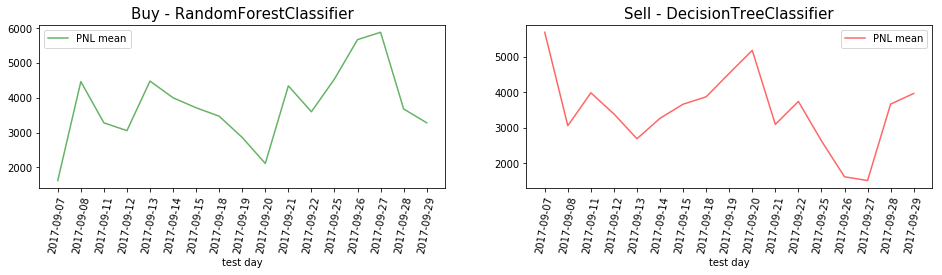

In [84]:
plt.figure(figsize=(16,3))
plt.subplot(1,2,1)
plt.title('Buy - RandomForestClassifier', size=15)
plt.plot(range(len(result_RFC[:,1])), result_RFC[:,1],color='green', alpha=0.6, label='PNL mean')
plt.xlabel('test day')
plt.xticks(range(len(result_RFC)),dates[n_bdtrain:], size=10, rotation=80)
plt.legend();

plt.subplot(1,2,2)
plt.title('Sell - DecisionTreeClassifier', size=15)
plt.plot(range(len(result_RFC[:,2])), result_RFC[:,2],color='red', alpha=0.6, label='PNL mean')
plt.xlabel('test day')
plt.xticks(range(len(result_RFC)),dates[n_bdtrain:], size=10, rotation=80)
plt.legend();